<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.13.Colab_NASA_DEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NASA Digital Elevation Model (DEM)
This notebook uses NASA's global Digital Elevation Model (NASADEM) from February 2000. NASADEM is a reprocessing of STRM data at 30-meters resolution, with improved accuracy by incorporating auxiliary data from ASTER GDEM, ICESat GLAS, and PRISM datasets.The most significant processing improvements involve void reduction through improved phase unwrapping and using ICESat GLAS data for control. More information about the dataset is available from the Google Earth Engine data catalog: [HERE](https://developers.google.com/earth-engine/datasets/catalog/NASA_NASADEM_HGT_001) 

## Instructions for Execution
It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for "MODIFY HERE" labels at the top of code blocks to identify code that can be modified. These include:<br>
<br>#1 - Select spatial region
<br>#2 - Select GeoTIFF output name
<br><br>
Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

--2022-03-01 16:16:12--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15292 (15K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  14.93K  --.-KB/s    in 0s      

2022-03-01 16:16:13 (97.9 MB/s) - ‘odc_colab.py’ saved [15292/15292]

Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Package postgresql was not found; installing it...
Module odc-gee was not found; cloning https://github.com/ceos-seo/odc-gee.git to CWD...


In [ ]:
from odc_colab import populate_db
populate_db()

No database file supplied. Downloading default index.
Cleaned up extracted database files.


## Load the Data Cube Configuration and Import Utilities

In [ ]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube(app='NASADEM_Product_Demo')

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.import_export import export_slice_to_geotiff
import folium
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

### Define Slope Function
* `dem`: The DEM product to use for slope map calculation.
* `resolution`: The resolution of the supplied DEM product.

In [ ]:
def slope_pct(dem, resolution):
    # Kernel for rate of elevation change in x-axis.
    dx_kernel = np.array([[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]])
    # Kernel for rate of elevation change in y-axis.
    dy_kernel = np.array([[1, 2, 1],
                          [0, 0, 0],
                          [-1, -2, -1]])
    # Rate of change calculations for each axis.
    dx = convolve(dem, dx_kernel) / (8 * resolution)
    dy = convolve(dem, dy_kernel) / (8 * resolution)
    # Return rise/run * 100 for slope percent.
    return np.sqrt(np.square(dx) + np.square(dy)) * 100

### Set Analysis Region and View

In [ ]:
#1 MODIFY HERE

# Jamaica (entire country)
latitude = (17.6235, 18.5838)
longitude = (-78.4424, -76.0968)

In [ ]:
f = folium.Figure(width=800, height=800)
m = display_map(latitude,longitude)
f.add_child(m)

## Load the data

In [ ]:
nasadem_dataset = dc.load(asset='NASA/NASADEM_HGT/001', output_crs='EPSG:4326', 
                          resolution=(-2.69493352e-4, 2.69493352e-4), 
                          latitude=latitude, longitude=longitude).isel(time=0)

In [ ]:
# View the dataset dimensions
# The latitude and longitude dimensions are in pixels
nasadem_dataset

<xarray.Dataset>
Dimensions:      (latitude: 3564, longitude: 8705)
Coordinates:
    time         datetime64[ns] 2000-02-11
  * latitude     (latitude) float64 18.58 18.58 18.58 ... 17.62 17.62 17.62
  * longitude    (longitude) float64 -78.44 -78.44 -78.44 ... -76.1 -76.1 -76.1
    spatial_ref  int32 4326
Data variables:
    elevation    (latitude, longitude) int16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    num          (latitude, longitude) uint8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    swb          (latitude, longitude) uint8 255 255 255 255 ... 255 255 255 255
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

# View Elevation and Slope Products

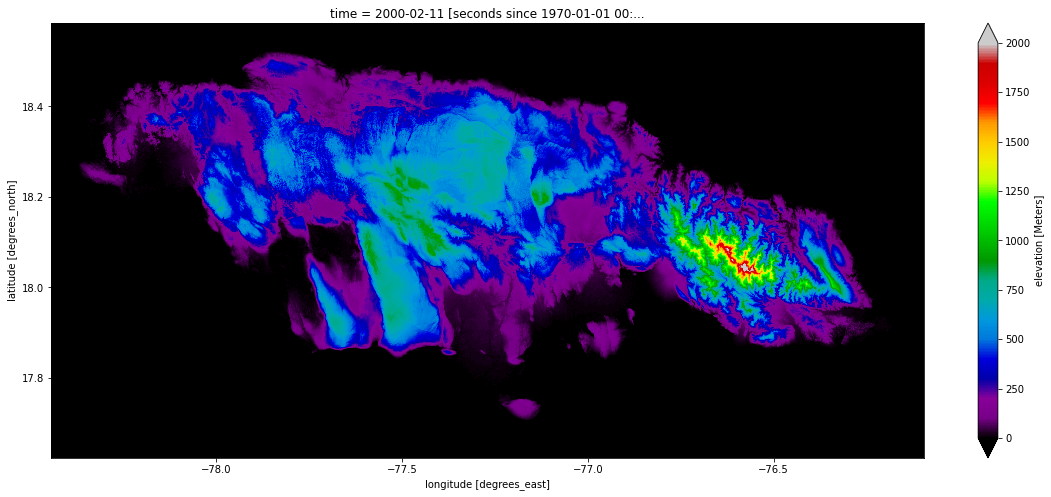

In [ ]:
aspect = nasadem_dataset.dims['longitude']/nasadem_dataset.dims['latitude']
nasadem_dataset.elevation.plot.imshow(size=8,cmap=plt.cm.nipy_spectral,vmin=0.0,vmax=2000.0,aspect=aspect);

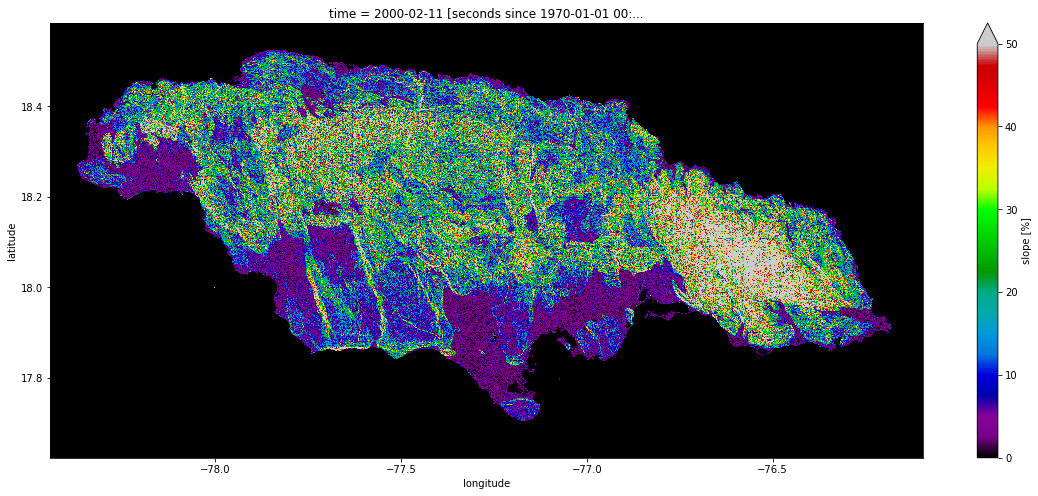

In [ ]:
aspect = nasadem_dataset.dims['longitude']/nasadem_dataset.dims['latitude']
attrs = nasadem_dataset.elevation.attrs.copy(); attrs.update(units='%')
nasadem_dataset['slope'] = xr.DataArray(slope_pct(nasadem_dataset.elevation,
                                               nasadem_dataset.geobox.resolution[1]*(1.1132/0.00001)),
                                     dims=dict(nasadem_dataset.dims),
                                     attrs=attrs)
nasadem_dataset.slope.plot.imshow(cmap=plt.cm.nipy_spectral, vmin=0.0, vmax=50.0, size=8, aspect=aspect);

## Create GeoTIFF Output Product

In [ ]:
#2 MODIFY HERE

# Change the name of the output file, or it will be overwritten for each run 
# The output file can be found using the "file" icon on the Colab menu on the left
# This output is stored temporarily, so download or move the file to your Google Drive for later use

# export_slice_to_geotiff(nasadem_dataset,'./output/DEM_Jamaica_example.tif')